In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


from scipy import stats
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.metrics import f1_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn import metrics

from xgboost import XGBClassifier, plot_tree
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import pickle


### Importation CSV et création du dataframe

In [22]:
df = pd.read_csv("data.csv")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56368,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
56369,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
56370,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
56371,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [23]:
df.drop_duplicates(inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45211 entries, 0 to 56372
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  deposit    45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.2+ MB


### Création de la matrice X (variables explicatives) et de la série y (variable cible)

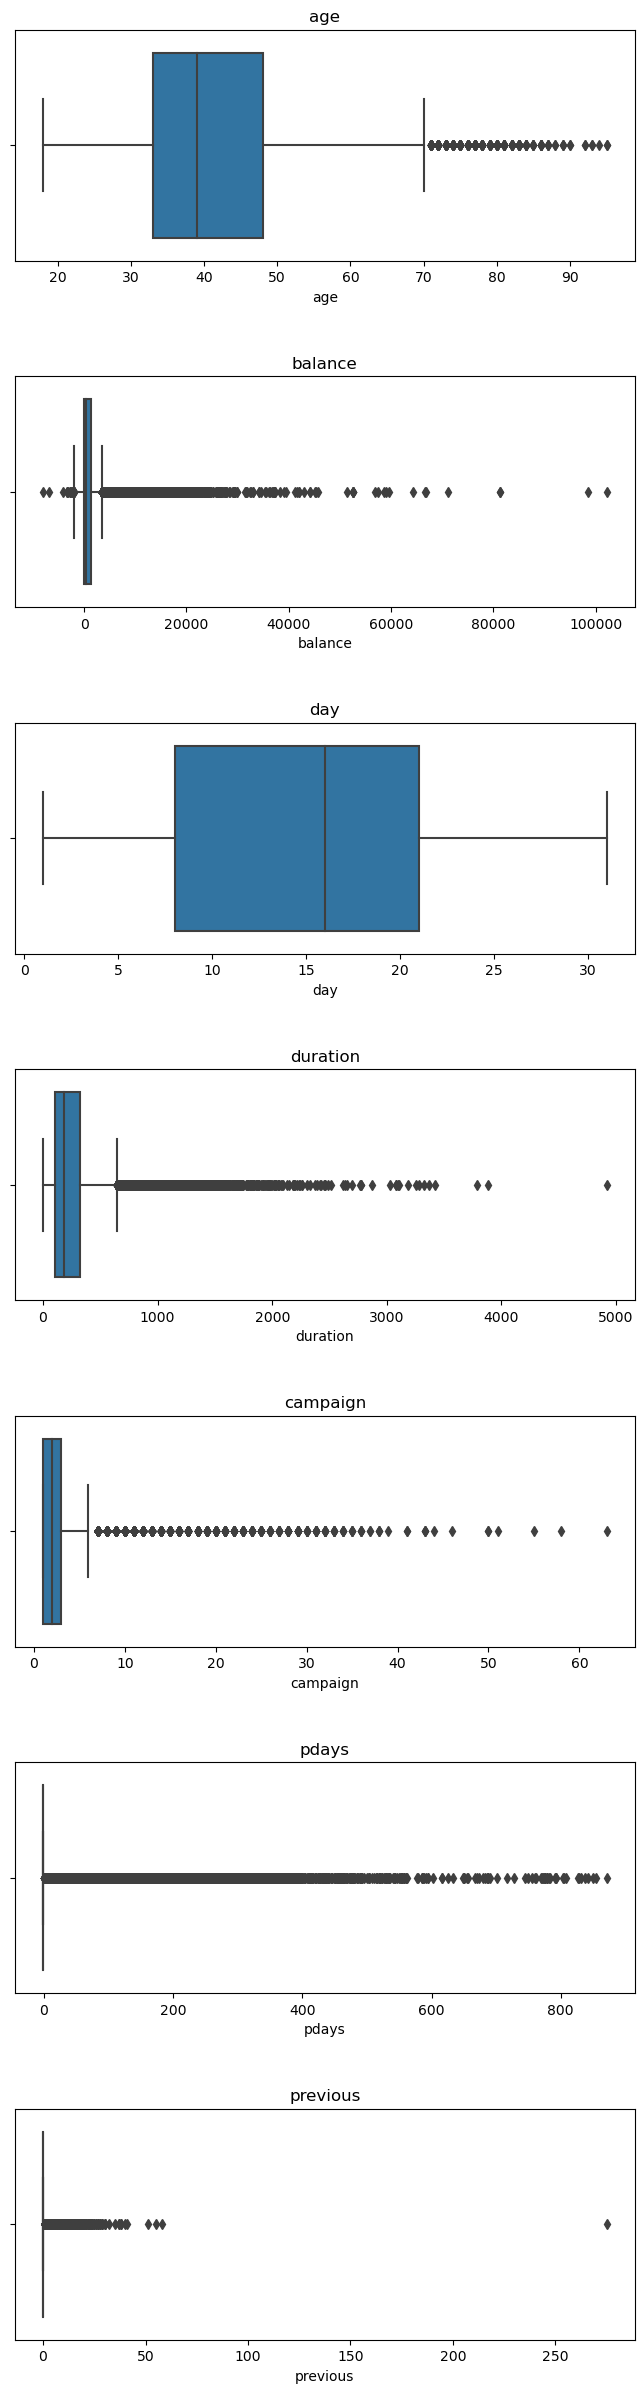

In [25]:
# Generate individual plot for the numerical variables, they are in different ranges

cols_num = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(8,30))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=df, ax=ax[i]) # "boxplot" can allow us to see the outliers points
    ax[i].set_title(col)

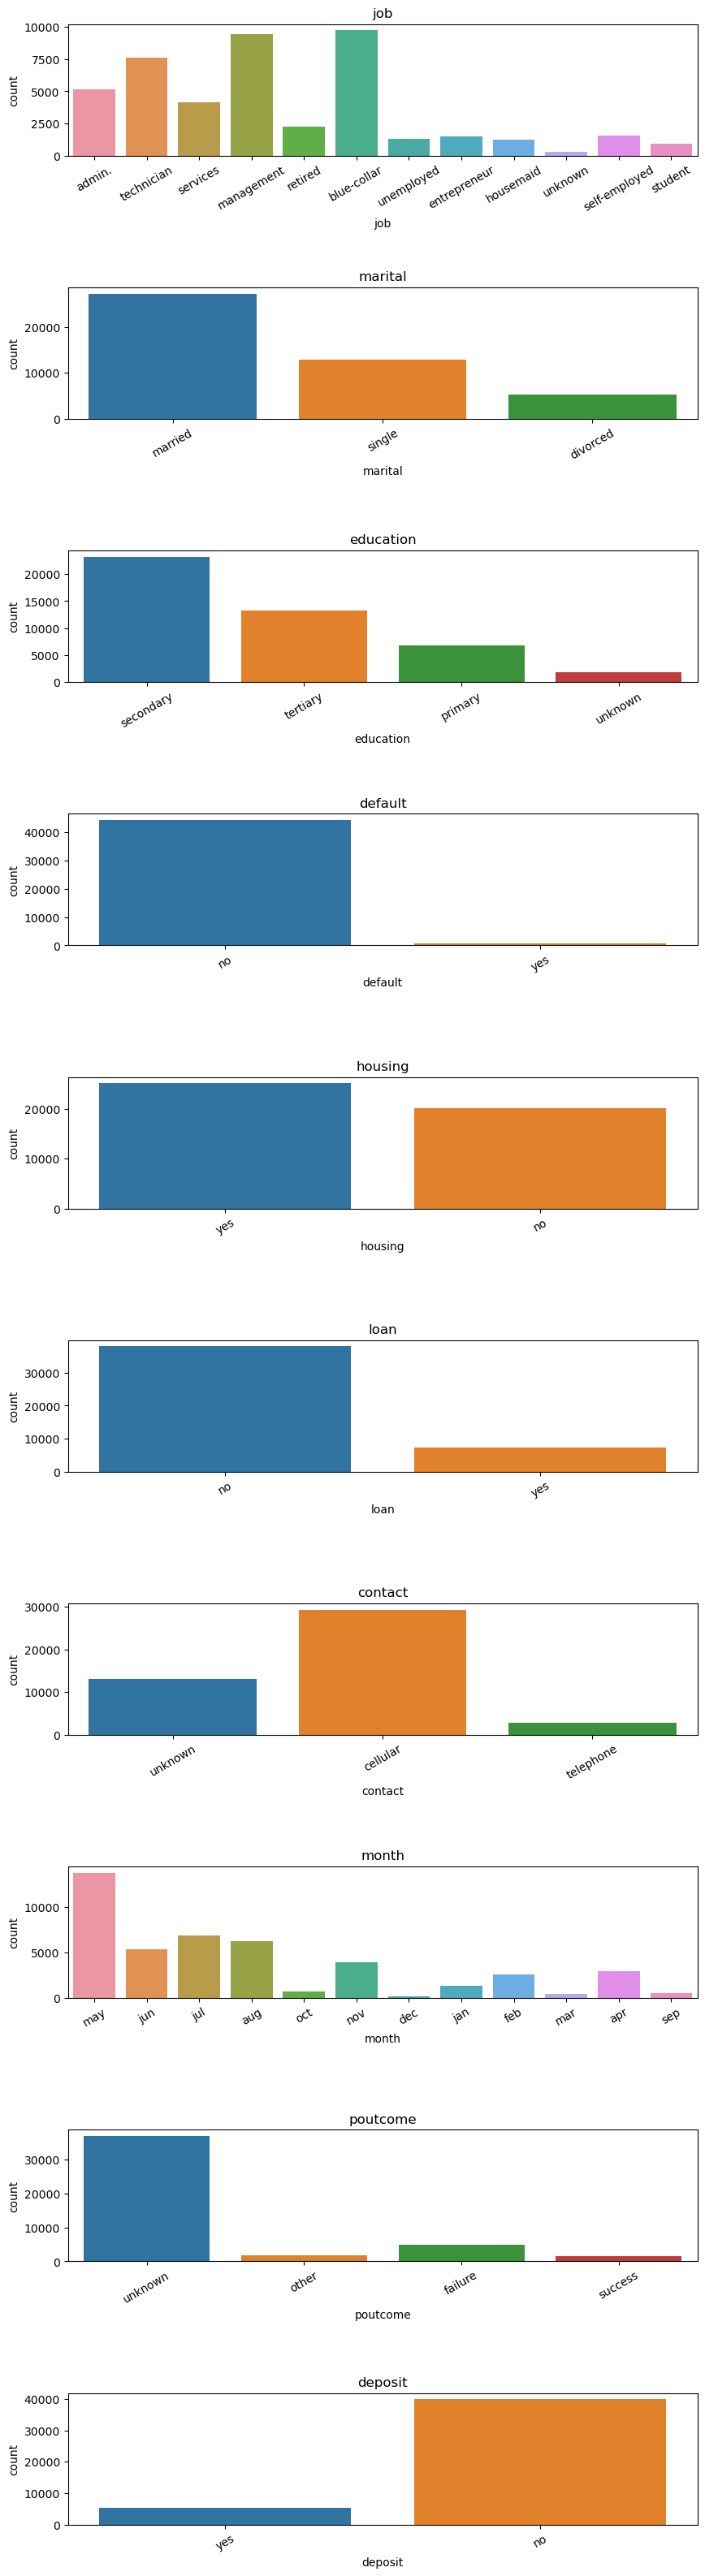

In [26]:
# Plots of sub-levels of each categorical's variables

cols_cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']

fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(10,40))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(cols_cat):
    sns.countplot(x=col, data=df, ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=30)

In [44]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42, stratify=y)

# Score du dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)



0.8830034280659074

### Création d'un pipeline

In [50]:
transformer = make_column_transformer(
    (OneHotEncoder(),make_column_selector(dtype_exclude=np.number)),
    (StandardScaler(),make_column_selector(dtype_include=np.number))
    )

### Création d'un  RandomForest

In [29]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        min_samples_leaf=1000,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

#Utilisation d'un .features_importances_ pour déterminer quelle variable est importante pour la prédiction
A=forest.named_steps['randomforestclassifier'].feature_importances_

# #Score de notre modèle après la cross_validation
cross_val=cross_validate(forest, X_train, y_train,scoring='f1',cv=5)

cross_val['test_score'].mean()

/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    return self._score(
  File "/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 268, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/apprenant/miniconda3/envs/model_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/home/apprenant/minicon

nan

[ 2893  9403 15913 22423 28934]


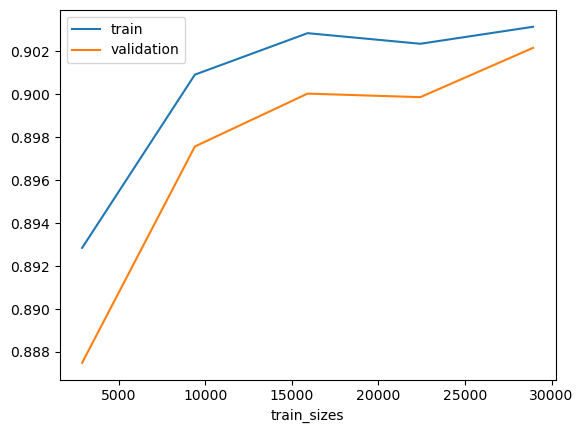

In [62]:
N, train_score, val_score = learning_curve(xgb, X_train, y_train,cv=5)
print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, pd.DataFrame(val_score).mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [30]:
# y_pred=forest.predict(X_train)
# f1_score(y_train,y_pred)

In [31]:
A_columns=transformer.get_feature_names_out()
A_columns

array(['onehotencoder__job_admin.', 'onehotencoder__job_blue-collar',
       'onehotencoder__job_entrepreneur', 'onehotencoder__job_housemaid',
       'onehotencoder__job_management', 'onehotencoder__job_retired',
       'onehotencoder__job_self-employed', 'onehotencoder__job_services',
       'onehotencoder__job_student', 'onehotencoder__job_technician',
       'onehotencoder__job_unemployed', 'onehotencoder__job_unknown',
       'onehotencoder__marital_divorced',
       'onehotencoder__marital_married', 'onehotencoder__marital_single',
       'onehotencoder__education_primary',
       'onehotencoder__education_secondary',
       'onehotencoder__education_tertiary',
       'onehotencoder__education_unknown', 'onehotencoder__default_no',
       'onehotencoder__default_yes', 'onehotencoder__housing_no',
       'onehotencoder__housing_yes', 'onehotencoder__loan_no',
       'onehotencoder__loan_yes', 'onehotencoder__contact_cellular',
       'onehotencoder__contact_telephone',
       'one

In [32]:
df_coeff = pd.DataFrame([A_columns,A], index=['features', 'coeff']).T.explode('coeff')
df_coeff.sort_values(by='coeff', ascending=False).head(20)

,features,coeff
47,standardscaler__duration,0.413078
27,onehotencoder__contact_unknown,0.098447
49,standardscaler__pdays,0.09724
22,onehotencoder__housing_yes,0.056305
25,onehotencoder__contact_cellular,0.047674
21,onehotencoder__housing_no,0.04642
43,onehotencoder__poutcome_unknown,0.045912
50,standardscaler__previous,0.044691
36,onehotencoder__month_may,0.028009
45,standardscaler__balance,0.024627


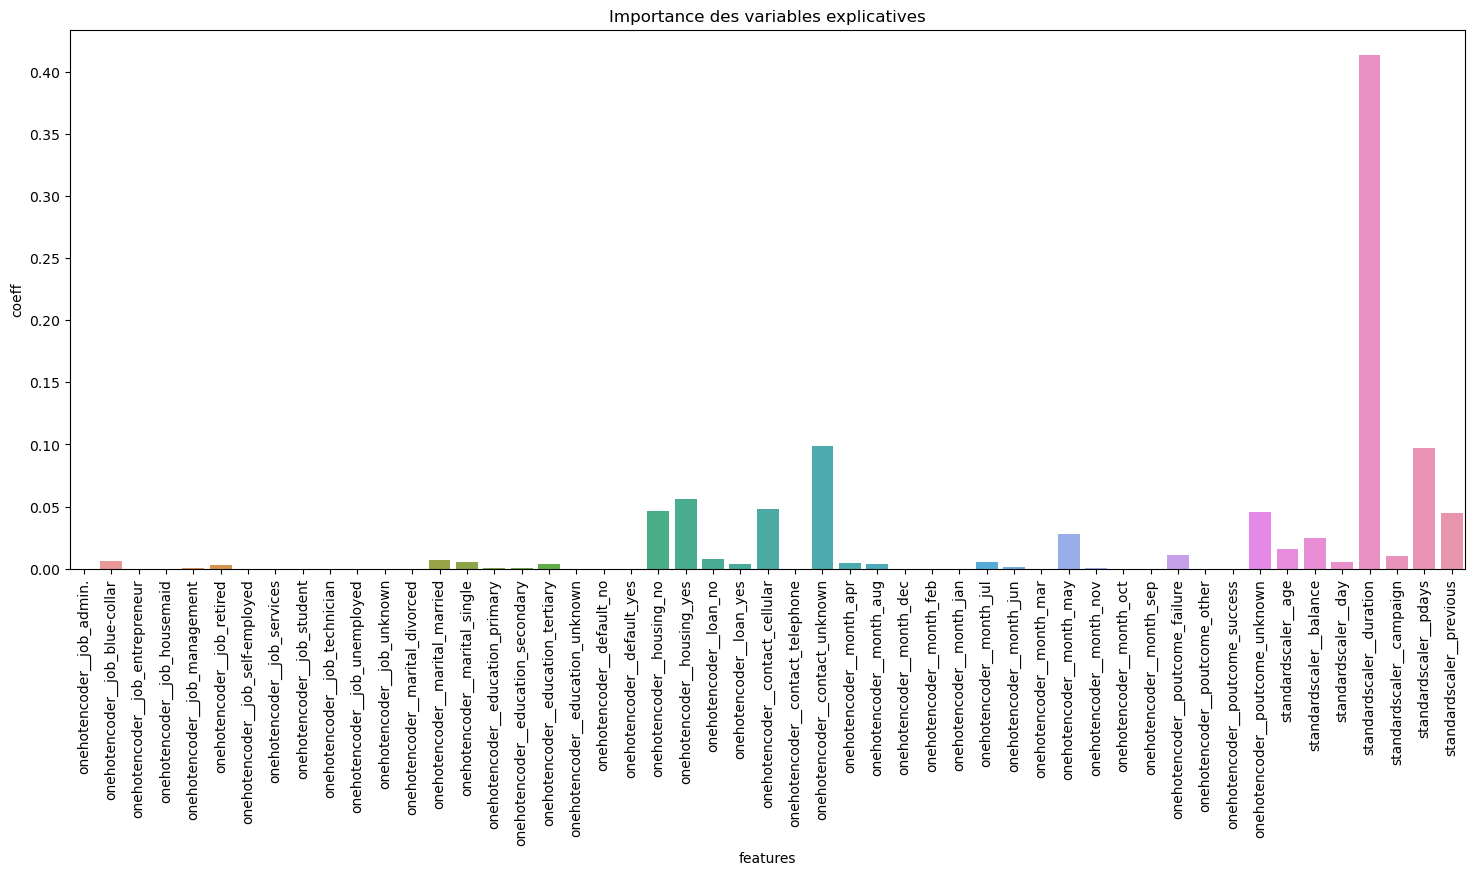

In [33]:
plt.figure(figsize=[18,7])
sns.barplot(data=df_coeff,x='features',y='coeff')
plt.xticks(rotation=90)
plt.title("Importance des variables explicatives")
plt.show()

In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45211 entries, 0 to 56372
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.9+ MB


In [36]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=10,
        n_estimators=100,
        min_samples_leaf=6000,
        min_samples_split=20000,
        max_leaf_nodes=15,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a8a469e50>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a8a4697f0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_leaf_nodes=15,
                                        min_samples_leaf=6000,
                                        min_samples_split=20000))])

In [37]:
# y_pred=cross_val_predict(forest,X_train, y_train)

In [38]:
y_pred=cross_val_predict(forest,X_train, y_train)

In [39]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          no       0.95      0.71      0.81     35929
         yes       0.25      0.73      0.37      4760

    accuracy                           0.71     40689
   macro avg       0.60      0.72      0.59     40689
weighted avg       0.87      0.71      0.76     40689



In [40]:
cross_val=cross_validate(forest, X_train, y_train,scoring='f1_macro',cv=5)

cross_val['test_score'].mean()

0.5941261348875863

# Modele XGB pour projet final

In [51]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']



In [52]:
def convert_labels(label):
    if label == 'no':
        return 0
    elif label == 'yes':
        return 1
    else:
        # Gérez le cas où la classe n'est ni 'no' ni 'yes', si nécessaire
        return None

# Appliquez la fonction de conversion aux étiquettes de classe
y= y.apply(convert_labels)


X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42, stratify=y)
# Vérifiez à nouveau les classes uniques
classes_uniques = y_train.unique()
print(classes_uniques)


[0 1]


In [78]:
xgb= make_pipeline(
        transformer,
        XGBClassifier(
            max_depth=20,
            learning_rate=0.1,
            n_estimators=100,
            gamma=50, 
            min_child_weight=0,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.005
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
xgb.fit(X_train,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a8a9f0040>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a8a907fa0>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None...
                               feature_types=None, gamma=50, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=20, max_leaves=None,
                               min_child_weight=0, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [79]:
xgb.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a8a9f0040>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a8a907fa0>)])),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.8, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=50, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.1, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, ma

In [80]:
A=xgb.named_steps['xgbclassifier'].feature_importances_
A_columns=transformer.get_feature_names_out()
A_columns

array(['onehotencoder__job_admin.', 'onehotencoder__job_blue-collar',
       'onehotencoder__job_entrepreneur', 'onehotencoder__job_housemaid',
       'onehotencoder__job_management', 'onehotencoder__job_retired',
       'onehotencoder__job_self-employed', 'onehotencoder__job_services',
       'onehotencoder__job_student', 'onehotencoder__job_technician',
       'onehotencoder__job_unemployed', 'onehotencoder__job_unknown',
       'onehotencoder__marital_divorced',
       'onehotencoder__marital_married', 'onehotencoder__marital_single',
       'onehotencoder__education_primary',
       'onehotencoder__education_secondary',
       'onehotencoder__education_tertiary',
       'onehotencoder__education_unknown', 'onehotencoder__default_no',
       'onehotencoder__default_yes', 'onehotencoder__housing_no',
       'onehotencoder__housing_yes', 'onehotencoder__loan_no',
       'onehotencoder__loan_yes', 'onehotencoder__contact_cellular',
       'onehotencoder__contact_telephone',
       'one

In [69]:
df_coeff = pd.DataFrame([A_columns,A], index=['features', 'coeff']).T.explode('coeff')
df_coeff.sort_values(by='coeff', ascending=False).head(20)

,features,coeff
42,onehotencoder__poutcome_success,0.127412
47,standardscaler__duration,0.107006
22,onehotencoder__housing_yes,0.052105
27,onehotencoder__contact_unknown,0.044501
21,onehotencoder__housing_no,0.037403
28,onehotencoder__month_apr,0.036111
34,onehotencoder__month_jun,0.035674
44,standardscaler__age,0.034065
35,onehotencoder__month_mar,0.033717
49,standardscaler__pdays,0.033536


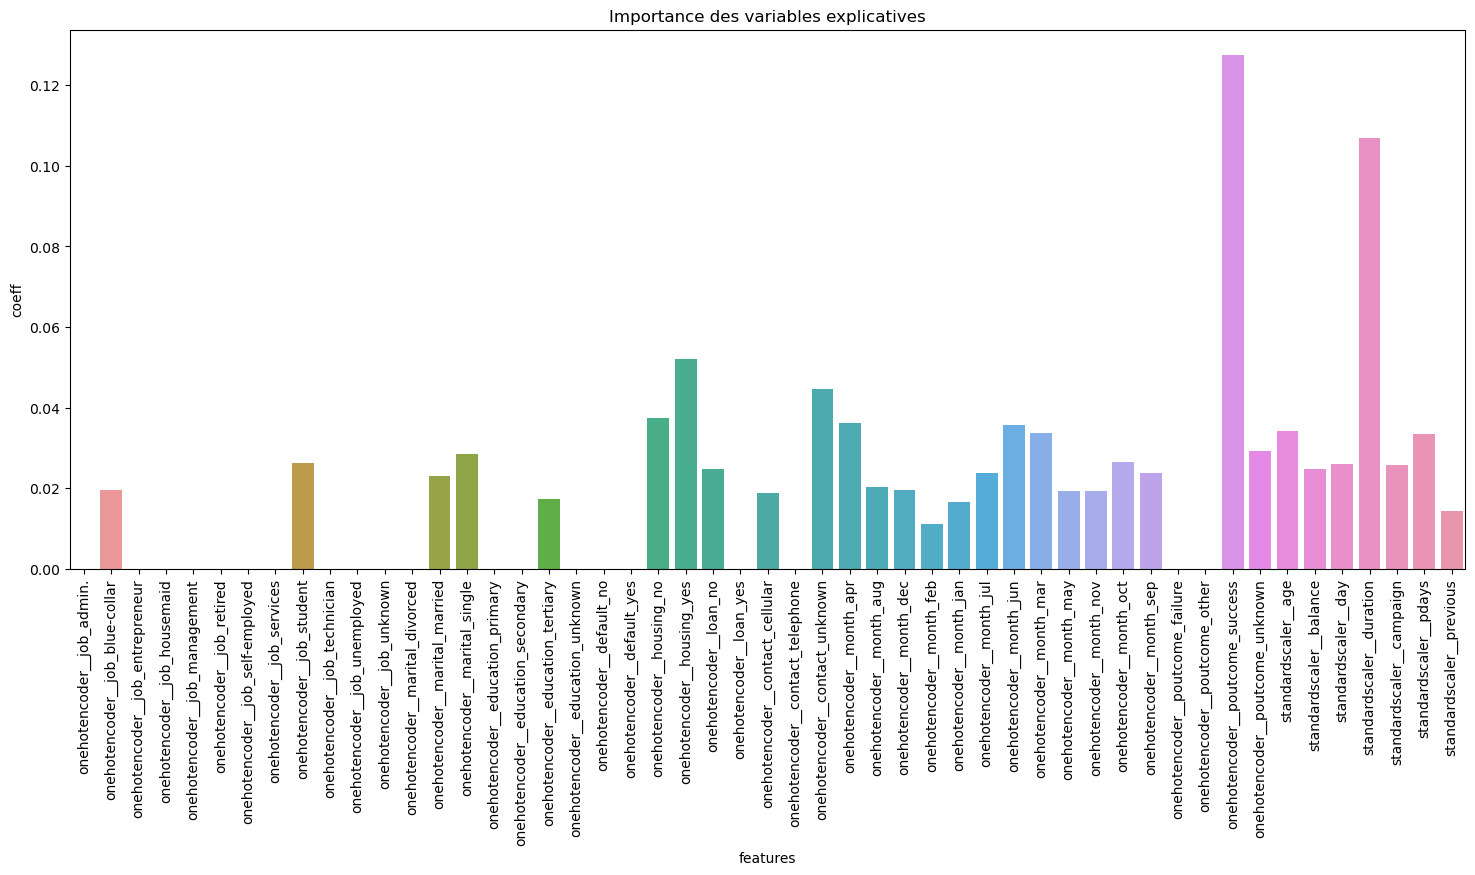

In [70]:
plt.figure(figsize=[18,7])
sns.barplot(data=df_coeff,x='features',y='coeff')
plt.xticks(rotation=90)
plt.title("Importance des variables explicatives")
plt.show()

In [64]:
cross_val=cross_validate(xgb, X_train, y_train,scoring='f1_macro',cv=5)

cross_val['test_score'].mean()

0.6847300811154511

In [56]:
y_pred=xgb.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     31937
           1       0.69      0.35      0.46      4231

    accuracy                           0.91     36168
   macro avg       0.80      0.66      0.71     36168
weighted avg       0.89      0.91      0.89     36168



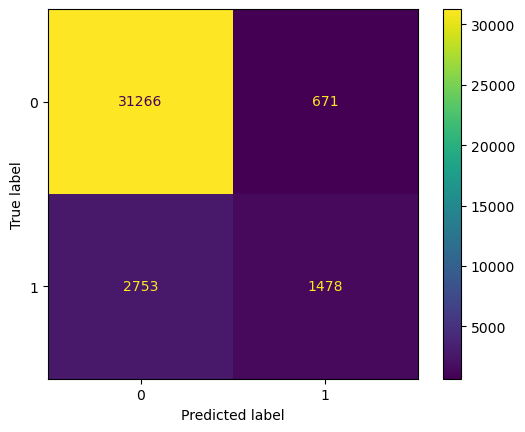

In [57]:
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [94]:
encoder = make_column_transformer(
    (OneHotEncoder(),['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']))


df_array= encoder.fit_transform(df)
df_columns= encoder.get_feature_names_out()
df_columns
newdf= pd.DataFrame(df_array).set_index(df.index)
newdf.columns = df_columns

# df_assurance.drop(['region','sex','smoker'])

# dfencoder= pd.merge(newdf, df, left_index=True, right_index=True)
# dfencoder

ValueError: Length mismatch: Expected axis has 1 elements, new values have 44 elements

### Utilisation d'un RandomSearch pour obtenir une idée de l'ordre de grandeur des paramètres

In [58]:
#Pour trouver le nom des paramètres590599
forest.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a8a469e50>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a8a4697f0>)])),
  ('randomforestclassifier',
   RandomForestClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=15,
                          min_samples_leaf=6000, min_samples_split=20000))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4a8a469e50>),
                                 ('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.ma

In [ ]:
# param_rand = {'randomforestclassifier__min_samples_leaf':np.arange(1000,10000,100),
#               'randomforestclassifier__max_depth':np.arange(5,10,1),
#               'randomforestclassifier__min_samples_split':np.arange(1000,10000,100)
#                 }
                
# random_search = RandomizedSearchCV(forest, param_distributions=param_rand,scoring='f1', n_iter=1, cv=5, random_state=42)

# random_search.fit(X_train, y_train)
# print(random_search.best_params_)

In [ ]:
# random_search.best_estimator_
# random_search.best_score_

### Utilisation d'un GridSearch pour cibler les meilleurs paramètres

In [ ]:
# params = {'randomforestclassifier__min_samples_leaf':np.arange(2150,2300,1),
#           'randomforestclassifier__max_depth':[6]
#             }

# grid=GridSearchCV(forest, param_grid=params, scoring='f1', cv=5)
# grid.fit(X_train, y_train)

In [ ]:
# grid.best_score_

In [ ]:
with open('xgb.pkl', 'wb') as file:
  pickle.dump(xgb, file)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803961 entries, 19306 to 508120
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   UrbanRural     803961 non-null  object 
 1   CreateJob      803961 non-null  int64  
 2   RetainedJob    803961 non-null  int64  
 3   NoEmp          803961 non-null  int64  
 4   Real_estate    803961 non-null  object 
 5   GrAppv         803961 non-null  float64
 6   Industry       803961 non-null  object 
 7   Term           803961 non-null  int64  
 8   FranchiseCode  803961 non-null  object 
 9   NewExist       803961 non-null  object 
 10  State          803961 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 73.6+ MB


In [ ]:
df

,State,BankState,Industry,Term,GrAppv,MIS_Status,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,Real_estate
0,IN,OH,Retail trade,84,60000.0,0,4,1,0,0,1,0,0
1,IN,IN,Accommodation and food services,60,40000.0,0,2,1,0,0,1,0,0
2,IN,IN,Health care and social assistance,180,287000.0,0,7,0,0,0,1,0,0
3,OK,OK,Others,60,35000.0,0,2,0,0,0,1,0,0
4,FL,FL,Others,240,229000.0,0,14,0,7,7,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
893285,OH,IL,Retail trade,60,70000.0,0,6,0,0,0,1,0,0
893286,OH,IL,Retail trade,60,85000.0,0,6,0,0,0,1,0,0
893287,CA,CA,Manufacturing,108,300000.0,0,26,0,0,0,1,0,0
893288,HI,HI,Others,60,75000.0,1,6,0,0,0,1,0,0


In [ ]:
import folium
import geopandas as gpd
# create a base map
def percent_of_CHGOFF(df):
    nb_CHGOFF = df[df=='0'].shape[0]
    nb_total = df.shape[0] 
    return round((nb_CHGOFF / nb_total)*100,2)
    

df_state = df[['State','MIS_Status']]
df_state = df_state.groupby('State').agg(percent_of_CHGOFF).rename(columns={'MIS_Status' : 'percent_of_CHGOFF'}).reset_index()
df_state

gdf = gpd.read_file('/home/apprenant/Bureau/loan/Loan_project/us-states.json')
gdf
m = folium.Map(location=[50, -95], zoom_start=3)

# read a GeoJSON file with Pandas

# # merge the data and the GeoJSON file
merged = gdf.merge(df_state, left_on='id', right_on='State')

# create a choropleth map
folium.Choropleth(
    geo_data=merged,
    name='choropleth',
    data=df_state,
    columns=['State', 'percent_of_CHGOFF'],
    key_on='feature.properties.id',
    fill_color='Reds',
    fill_opacity=1,
    line_opacity=0.4,
    legend_name='pourcentage de non remboursement'
).add_to(m)

# ajouter des marqueurs pour chaque état
for row in merged.itertuples():
    if row.percent_of_CHGOFF > 21 :
        folium.Marker(location=[row.geometry.centroid.y, row.geometry.centroid.x], popup=row.name).add_to(m)


folium.LayerControl().add_to(m)
# afficher la carte
display(m)


ModuleNotFoundError: No module named 'folium'